In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.interpolate import griddata


from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns


In [2]:
class GaussianMixtureModel:
    '''
     This class implements a Gaussian Mixture Model which has several methods for 
     data generation, likelihood calculation, and visualization of the results.
     
    '''
    def __init__(self, n_dimensions, n_components, means, covs, weights):
        '''
        Initializes the class with the number of dimensions, number of components, 
        means, covariance matrices, and weights for each dimension.
        
        Arguments
        n_dimensions [int]: number of dimensions of dataset
        n_components [int]: number of components in the input data
        means [list]: means for each Gaussian component
        covs [list]: covariance matrices for each Gaussian component
        weights [list]: weights for each Gaussian component
        
        '''
        self.n_dimensions = n_dimensions
        self.n_components = n_components
        self.means = means
        self.covs = covs
        self.weights = weights
    
    
    def generate_data(self, n_samples):
        '''
        Generates data samples from the Gaussian Mixture Model.
        It takes the number of samples as input and returns the generated samples.

        Arguments
        n_samples [int]: number of samples in dataset 

        Returns
        X [np.array]: generated dataset which will be used later

        '''
        X = np.empty((n_samples, self.n_dimensions)) # initialize an empty numpy array with the shape to store generated samples
        for i in range(n_samples): 
            component = np.random.choice(self.n_components, p = self.weights)
            X[i, :] = np.random.multivariate_normal(self.means[component], self.covs[component]) 

        return X # return generated dataset 
    
    
    def plot_scatter(self, X):
        '''
        Plots scatter plot for data.
        
        Arguments
        X [np.array]: dataset for which scatter plot will be plotted
        
        Returns
        None
                
        '''
        plt.rcParams["figure.figsize"] = (8, 6)
        
        n_dimensions = X.shape[1]
        
        # 2D data
        if n_dimensions == 2:
            plt.scatter(X[:, 0], X[:, 1], marker = 'o', s = 6, alpha = 0.5)
            plt.title("Scatter plot for Gaussian Mixture Model")
            plt.xlabel("$\mu1$")
            plt.ylabel("$\mu2$")
            plt.savefig('2Dscatter')
            plt.show()
        
        # 3D data
        elif n_dimensions == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection = '3d')
            ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker = 'o', s = 6, alpha = 0.5)
            plt.title("Scatter plot for Gaussian Mixture Model")
            ax.set_xlabel("$\mu1$")
            ax.set_ylabel("$\mu2$")
            ax.set_zlabel("$\mu3$")
            plt.savefig('3Dscatter')
            plt.show()
            

    def plot_histograms(self, X):
        '''
        Plots histograms for data.

        Arguments
        X [np.array]: dataset for which histograms will be plotted
        
        Returns
        None

        '''

        fig, axs = plt.subplots(X.shape[1], 1, figsize = (6, 3 * X.shape[1]), sharex = True, sharey = True)
        fig.suptitle("Histograms")

        for i in range(X.shape[1]):
            sns.distplot(X[:, i], ax = axs[i])
            axs[i].set_title("$\mu$" + str(i + 1))
            axs[i].set_ylabel("Frequency")
        plt.savefig('hist') 
        plt.show()
        
        

    def pdf(self, X):
        '''
        Calculates the probability density function (pdf) of the Gaussian Mixture Model 
        for a given set of samples in X.
    
    
            p(x_j|θ) is the probability density function at each independent sample with
            θ represents the parameters mean, covariance, and mixture coefficients,
            and x_1, x_2, ... , x_n are the observed samples in dataset X.
        
        
        Arguments
        X [np.array]: dataset for which pdf will be calculated

        Returns
        probs [np.array]: probabilities of the Gaussian Mixture Model for each sample in X
        
        '''
        prob = np.zeros((X.shape[0], self.n_components)) # initialize a numpy array of zeros to store probs of each sample

        for i in range(self.n_components):
            # calculate pdf of each component at each sample in X
            prob[:, i] = self.weights[i] * multivariate_normal.pdf(X, mean = self.means[i], cov = self.covs[i])
        probs = np.sum(prob, axis = 1) # sum probabilities of each component at each sample
        
        return probs

         
        
    def calculate_likelihoods(self, X):
        '''
        Calculates the likelihood of the Gaussian Mixture Model for a given set of samples in X.


            The likelihood is calculated as the product of individual pdfs at the observed samples:

            L(θ) = p(x_1, x_2, ..., x_N|θ) = Π_j=1^N p(x_j|θ)

            Since likelihood of each point may be very small, leading to extremely small products, 
            a log likelihood is often used in practice:

            logL(θ) = Σ_j=1^N log(p(x_j|θ)) 

        
        Arguments
        X [np.array]: dataset for which log-likelihoods will be calculated

        Returns
        log_likelihoods [np.array]: log-likelihood of each sample in dataset X
        
        '''

        log_likelihoods = np.zeros(X.shape[0]) # initialize a numpy array of zeros to store log-likelihoods of each sample
        
        for i, x in enumerate(X):
            log_likelihood = 0 
            for j in range(self.n_components):
                # calculate log-likelihood of each sample by
                # adding product of mixture coefficient and pdf at sample x_j for each Gaussian component k
                log_likelihood += self.weights[j] * multivariate_normal.pdf(x, mean = self.means[j], cov = self.covs[j])
            log_likelihoods[i] = np.log(log_likelihood) # store in log_likelihoods numpy array
        
        return log_likelihoods # return log-likelihood of each sample in dataset X


    def plot_likelihood(self, X, probs):
        '''
        Plots the likelihood surface of data.

        Arguments
        X [np.array]: dataset for which scatterplot will be plotted
        probs [np.array]: probabilities of the Gaussian Mixture Model for each sample in X
        
        Returns
        None

        '''
        if self.n_dimensions == 2:
            fig = plt.figure(figsize = (8, 8), facecolor = "white")
            ax = fig.add_subplot(projection = "3d")
            
            x = X[:, 0]
            y = X[:, 1]
            z = probs
            
            # interpolate the points to make the plot smoother
            xi = np.linspace(min(x), max(x), 500)
            yi = np.linspace(min(y), max(y), 500)
            X, Y = np.meshgrid(xi, yi)
            Z = griddata((x, y), z, (X, Y), method='cubic')

            # plot the wireframe
            ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
            
            # plot scatter plot
            ax.scatter(x, y, z, color = 'r',  marker = '.', alpha = 0.7)

            ax.set_xlabel("mu1")
            ax.set_ylabel("mu2")
            ax.set_zlabel("Likelihood")
            ax.set_title("Likelihood Plot")
            fig.tight_layout()
            plt.savefig('likelihood')
            fig.show()



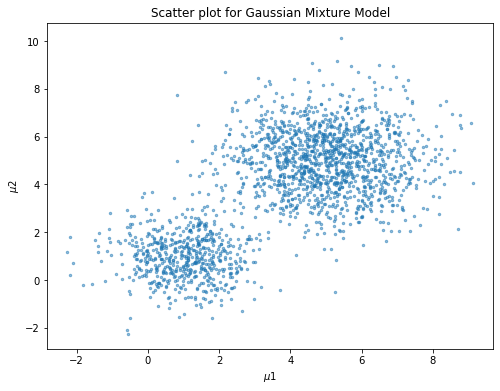

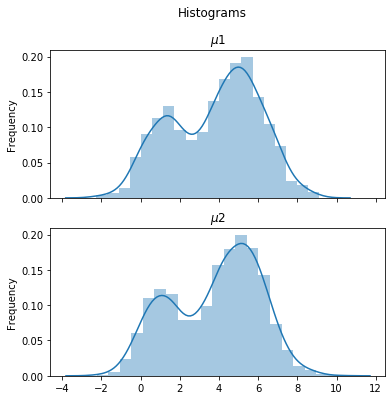

[0.02526363 0.02061476 0.02727705 ... 0.05077863 0.0366451  0.04662291]
[-3.67838941 -3.88174803 -3.60170955 ... -2.98027974 -3.30647543
 -3.0656632 ]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:211: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


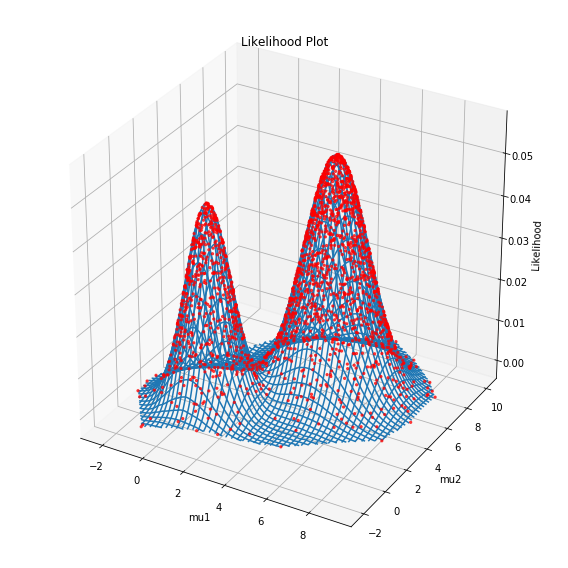

In [3]:
# Define the Gaussian Mixture Model with 2 dimensions and 2 components
dimensions = 2
components = 2

gmm1 = GaussianMixtureModel(n_dimensions = dimensions, 
                            n_components = components, 
                           means = [[1, 1], [5, 5]], 
                           covs = [[[1, 0], [0, 1]], 
                                 [[2, 0], [0, 2]]], 
                           weights = [0.3, 0.7])


# Initialize the Gaussian Mixture Model class with n samples
n_samples = 2000
X1 = gmm1.generate_data(n_samples)


# Plot the data X
gmm1.plot_scatter(X1)


# Plot the histograms of data X
gmm1.plot_histograms(X1)


# Calculate pdf of the data X 
prob1 = gmm1.pdf(X1)
print(prob1)


# Calculate log-likelihoods of data X
log_likelihood1 = gmm1.calculate_likelihoods(X1)
print(log_likelihood1)

# Plot the likelihoods of data X
gmm1.plot_likelihood(X1, prob1)

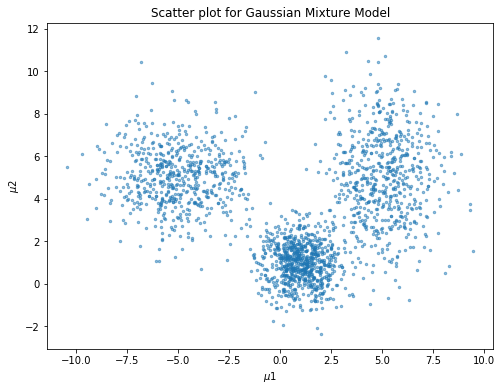

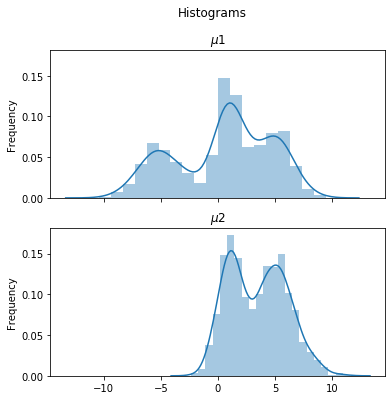

[0.02526363 0.02061476 0.02727705 ... 0.05077863 0.0366451  0.04662291]
[-3.67838941 -3.88174803 -3.60170955 ... -2.98027974 -3.30647543
 -3.0656632 ]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:211: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


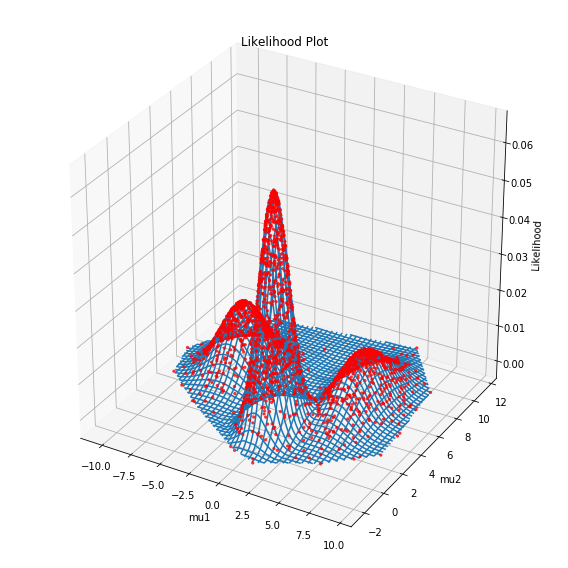

In [4]:
# Define the Gaussian Mixture Model with 2 dimensions and 3 components
dimensions = 2
components = 3

gmm2 = GaussianMixtureModel(n_dimensions = dimensions, 
                            n_components = components, 
                           means = [[1, 1], [-5, 5], [5, 5]], 
                           covs = [[[1, 0], [0, 1]], 
                                   [[3, 0], [0, 2]],
                                   [[2, 0], [0, 5]]],
                           weights = [0.4, 0.3, 0.3])


# Initialize the Gaussian Mixture Model class with n samples
n_samples = 2000
X2 = gmm2.generate_data(n_samples)


# Plot the data X
gmm2.plot_scatter(X2)


# Plot the histograms of data X
gmm2.plot_histograms(X2)


# Calculate pdf of the data X 
prob2 = gmm2.pdf(X2)
print(prob1)


# Calculate log-likelihoods of data X
log_likelihood2 = gmm2.calculate_likelihoods(X2)
print(log_likelihood1)

# Plot the likelihoods of data X
gmm2.plot_likelihood(X2, prob2)

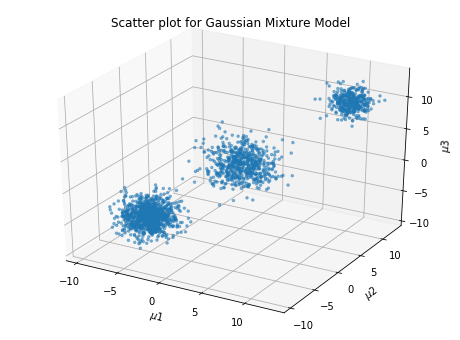

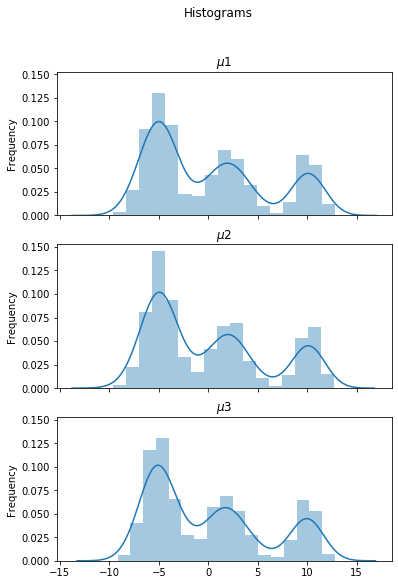

[0.00150764 0.01165209 0.00014116 ... 0.00255767 0.00616138 0.00284142]
[-6.49720888 -4.45226972 -8.86564502 ... -5.96866011 -5.08945476
 -5.8634516 ]


In [6]:
# Define the Gaussian Mixture Model with 3 dimensions and 3 components
dimensions = 3
components = 3

gmm3 = GaussianMixtureModel(n_dimensions = dimensions, 
                           n_components = dimensions, 
                           means = [[10, 10, 10], [-5, -5, -5], [2, 2, 2]], 
                           covs = [[[1, 0, 0], [0, 1, 0], [0, 0, 1]], 
                                   [[2, 0, 0], [0, 2, 0], [0, 0, 2]],
                                   [[3, 0, 0], [0, 3, 0], [0, 0, 3]]], 
                           weights=[0.2, 0.5, 0.3])


# Initialize the Gaussian Mixture Model class with n samples
n_samples = 2000
X3 = gmm3.generate_data(n_samples)


# Plot the data X
gmm3.plot_scatter(X3)


# Plot the histograms of the data X
gmm3.plot_histograms(X3)


prob3 = gmm3.pdf(X3)
print(prob3)


# Calculate the likelihood of the data X
log_likelihood3 = gmm3.calculate_likelihoods(X3)
print(log_likelihood3)


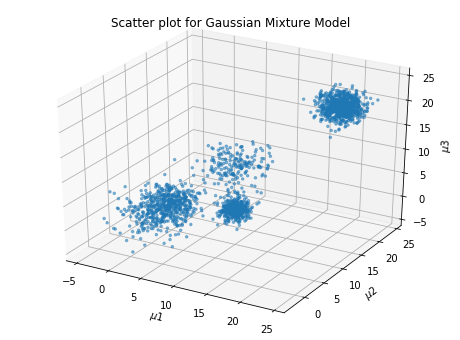

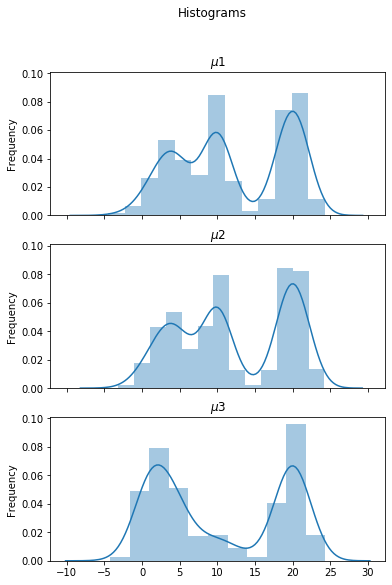

[7.98746390e-05 8.08798218e-03 1.57461761e-04 ... 9.07618307e-04
 1.44871412e-04 5.68431382e-04]
[-9.43505217 -4.817376   -8.75632791 ... -7.00468663 -8.83966402
 -7.47262995]


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian Mixture Model with 3 dimensions and 5 components
dimensions = 3
components = 5

gmm4 = GaussianMixtureModel(n_dimensions = dimensions, 
                           n_components = components, 
                            means = [[10, 10, 1], [2, 2, 2], [20, 20, 20], [4, 4, 4], [10, 10, 10]],
                            covs = [[[1, 0, 0], [0, 1, 0], [0, 0, 1]], 
                                    [[5, 0, 0], [0, 5, 0], [0, 0, 5]],
                                    [[2, 0, 0], [0, 2, 0], [0, 0, 2]],
                                    [[3, 0, 0], [0, 3, 0], [0, 0, 3]],
                                    [[5, 0, 0], [0, 5, 0], [0, 0, 5]]],
                            weights = [0.2, 0.1, 0.4, 0.2, 0.1])
                    
    
# Initialize the Gaussian Mixture Model class with n samples
n_samples = 2000
X4 = gmm4.generate_data(n_samples)


# Plot the data X
gmm4.plot_scatter(X4)


# Plot the histograms of the data X
gmm4.plot_histograms(X4)


# Calculate pdf of the data X 
prob4 = gmm4.pdf(X4)
print(prob4)


# Calculate log-likelihoods of data X
log_likelihood4 = gmm4.calculate_likelihoods(X4)
print(log_likelihood4)

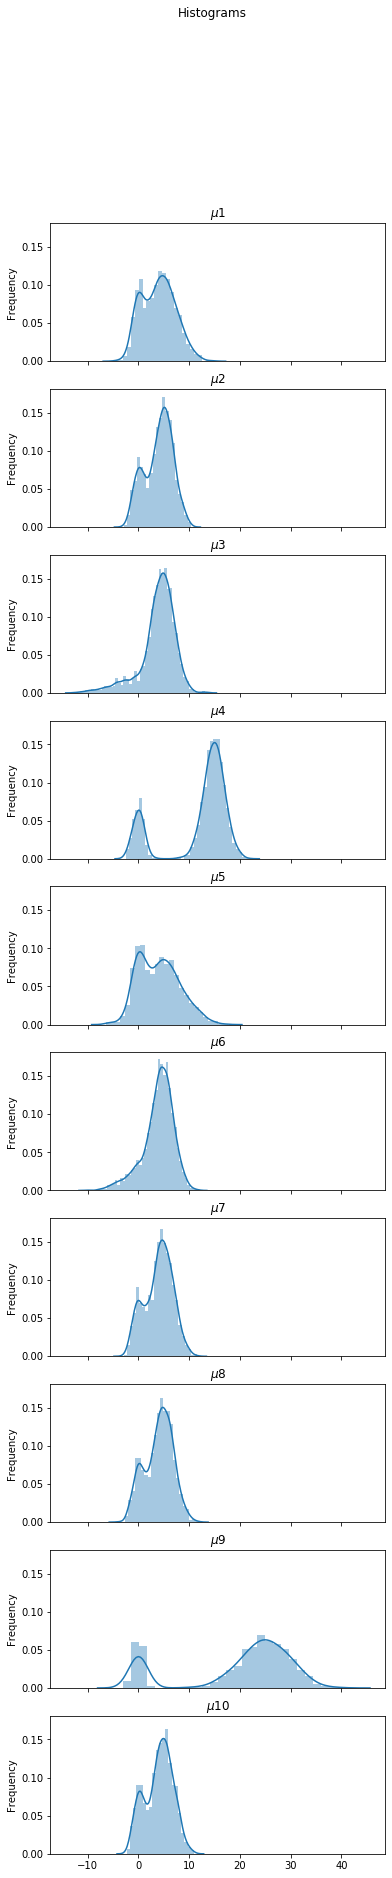

[2.70618136e-10 5.09903363e-11 1.28613418e-09 ... 4.05261761e-08
 1.96260808e-08 8.65703594e-10]
[-22.03031238 -23.69938499 -20.47162487 ... -17.02131775 -17.7464065
 -20.86747854]


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian Mixture Model with 10 dimensions and 2 components
dimensions = 10
components = 2


gmm5 = GaussianMixtureModel(n_dimensions = dimensions, 
                           n_components = components, 
                            means = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                     [5, 5, 5, 15, 5, 5, 5, 5, 25, 5]],
                            covs = [[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
                                     [0, 0, 21, 0, 0, 0, 0, 0, 0, 0], 
                                     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 
                                     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
                                     [0, 0, 0, 0, 0, 10, 0, 0, 0, 0], 
                                     [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 
                                     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 
                                     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 
                                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], 
                                    [[8, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                     [0, 4, 0, 0, 0, 0, 0, 0, 0, 0], 
                                     [0, 0, 4, 0, 0, 0, 0, 0, 0, 0], 
                                     [0, 0, 0, 4, 0, 0, 0, 0, 0, 0], 
                                     [0, 0, 0, 0, 14, 0, 0, 0, 0, 0], 
                                     [0, 0, 0, 0, 0, 4, 0, 0, 0, 0], 
                                     [0, 0, 0, 0, 0, 0, 4, 0, 0, 0], 
                                     [0, 0, 0, 0, 0, 0, 0, 4, 0, 0], 
                                     [0, 0, 0, 0, 0, 0, 0, 0, 24, 0], 
                                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 4]]],
                            weights = [0.2, 0.8])
            
    
# Initialize the Gaussian Mixture Model class with n samples
n_samples = 2000
X5 = gmm5.generate_data(n_samples)


# Plot the histograms of the data X
gmm5.plot_histograms(X5)


# Calculate pdf of the data X 
prob5 = gmm5.pdf(X5)
print(prob5)


# Calculate log-likelihoods of data X
log_likelihood5 = gmm5.calculate_likelihoods(X5)
print(log_likelihood5)
